In [5]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='iUZj_xocQAxwGUba0IEvgqEwHXcaMCT3EkhVOVXJ60yk',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.eu.cloud-object-storage.appdomain.cloud')

bucket = 'flightdelay-donotdelete-pr-k6u3ulqavon8e1'
object_key = 'flightdata.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data= pd.read_csv(body)
data.head()


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

**Importing the dataset**

In [7]:
data.head(10)

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN
5,2016,1,1,1,5,DL,N936DL,1975,13487,MSP,...,1459,1441.0,-18.0,0.0,0.0,0.0,150.0,134.0,907.0,NaN
6,2016,1,1,2,6,DL,N983DL,2074,10397,ATL,...,1931,1920.0,-11.0,0.0,0.0,0.0,166.0,155.0,907.0,NaN
7,2016,1,1,2,6,DL,N589NW,2151,13487,MSP,...,1929,1908.0,-21.0,0.0,0.0,0.0,229.0,197.0,1399.0,NaN
8,2016,1,1,2,6,DL,N804DN,2221,13487,MSP,...,1305,1255.0,-10.0,0.0,0.0,0.0,230.0,220.0,1399.0,NaN
9,2016,1,1,2,6,DL,N965DN,2291,13487,MSP,...,1801,1800.0,-1.0,0.0,0.0,0.0,151.0,137.0,907.0,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11231 entries, 0 to 11230
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 11231 non-null  int64  
 1   QUARTER              11231 non-null  int64  
 2   MONTH                11231 non-null  int64  
 3   DAY_OF_MONTH         11231 non-null  int64  
 4   DAY_OF_WEEK          11231 non-null  int64  
 5   UNIQUE_CARRIER       11231 non-null  object 
 6   TAIL_NUM             11231 non-null  object 
 7   FL_NUM               11231 non-null  int64  
 8   ORIGIN_AIRPORT_ID    11231 non-null  int64  
 9   ORIGIN               11231 non-null  object 
 10  DEST_AIRPORT_ID      11231 non-null  int64  
 11  DEST                 11231 non-null  object 
 12  CRS_DEP_TIME         11231 non-null  int64  
 13  DEP_TIME             11124 non-null  float64
 14  DEP_DELAY            11124 non-null  float64
 15  DEP_DEL15            11124 non-null 

In [9]:
data=data.drop('Unnamed: 25',axis=1)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11231 entries, 0 to 11230
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 11231 non-null  int64  
 1   QUARTER              11231 non-null  int64  
 2   MONTH                11231 non-null  int64  
 3   DAY_OF_MONTH         11231 non-null  int64  
 4   DAY_OF_WEEK          11231 non-null  int64  
 5   UNIQUE_CARRIER       11231 non-null  object 
 6   TAIL_NUM             11231 non-null  object 
 7   FL_NUM               11231 non-null  int64  
 8   ORIGIN_AIRPORT_ID    11231 non-null  int64  
 9   ORIGIN               11231 non-null  object 
 10  DEST_AIRPORT_ID      11231 non-null  int64  
 11  DEST                 11231 non-null  object 
 12  CRS_DEP_TIME         11231 non-null  int64  
 13  DEP_TIME             11124 non-null  float64
 14  DEP_DELAY            11124 non-null  float64
 15  DEP_DEL15            11124 non-null 

In [11]:
data.describe()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_TIME,...,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE
count,11231.0,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11124.000000,...,11124.000000,11231.000000,11116.000000,11043.000000,11043.000000,11231.000000,11231.000000,11231.000000,11043.000000,11231.000000
mean,2016.0,2.544475,6.628973,15.790758,3.960199,1334.325617,12334.516695,12302.274508,1320.798326,1327.189410,...,0.142844,1537.312795,1523.978499,-2.573123,0.124513,0.010150,0.006589,190.652124,179.661233,1161.031965
std,0.0,1.090701,3.354678,8.782056,1.995257,811.875227,1595.026510,1601.988550,490.737845,500.306462,...,0.349930,502.512494,512.536041,39.232521,0.330181,0.100241,0.080908,78.386317,77.940399,643.683379
min,2016.0,1.000000,1.000000,1.000000,1.000000,7.000000,10397.000000,10397.000000,10.000000,1.000000,...,0.000000,2.000000,1.000000,-67.000000,0.000000,0.000000,0.000000,93.000000,75.000000,509.000000
25%,2016.0,2.000000,4.000000,8.000000,2.000000,624.000000,10397.000000,10397.000000,905.000000,905.000000,...,0.000000,1130.000000,1135.000000,-19.000000,0.000000,0.000000,0.000000,127.000000,117.000000,594.000000
50%,2016.0,3.000000,7.000000,16.000000,4.000000,1267.000000,12478.000000,12478.000000,1320.000000,1324.000000,...,0.000000,1559.000000,1547.000000,-10.000000,0.000000,0.000000,0.000000,159.000000,149.000000,907.000000
75%,2016.0,3.000000,9.000000,23.000000,6.000000,2032.000000,13487.000000,13487.000000,1735.000000,1739.000000,...,0.000000,1952.000000,1945.000000,1.000000,0.000000,0.000000,0.000000,255.000000,236.000000,1927.000000
max,2016.0,4.000000,12.000000,31.000000,7.000000,2853.000000,14747.000000,14747.000000,2359.000000,2400.000000,...,1.000000,2359.000000,2400.000000,615.000000,1.000000,1.000000,1.000000,397.000000,428.000000,2422.000000


**Handling Missing Values**

In [12]:
data=data.dropna()

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11043 entries, 0 to 11230
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 11043 non-null  int64  
 1   QUARTER              11043 non-null  int64  
 2   MONTH                11043 non-null  int64  
 3   DAY_OF_MONTH         11043 non-null  int64  
 4   DAY_OF_WEEK          11043 non-null  int64  
 5   UNIQUE_CARRIER       11043 non-null  object 
 6   TAIL_NUM             11043 non-null  object 
 7   FL_NUM               11043 non-null  int64  
 8   ORIGIN_AIRPORT_ID    11043 non-null  int64  
 9   ORIGIN               11043 non-null  object 
 10  DEST_AIRPORT_ID      11043 non-null  int64  
 11  DEST                 11043 non-null  object 
 12  CRS_DEP_TIME         11043 non-null  int64  
 13  DEP_TIME             11043 non-null  float64
 14  DEP_DELAY            11043 non-null  float64
 15  DEP_DEL15            11043 non-null 

**DATA VISUALIZATION**

Text(0.5, 1.0, 'Distribution of the Arrival Time')

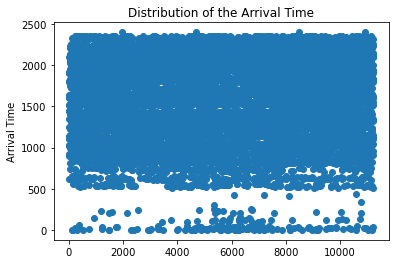

In [14]:
plt.scatter(data.index,data['ARR_TIME'])
plt.ylabel('Arrival Time')
plt.title('Distribution of the Arrival Time')

(array([ 989., 1487., 1340., 1382.,  924.,  957., 1058., 1111.,  987.,
         808.]),
 array([   7. ,  291.6,  576.2,  860.8, 1145.4, 1430. , 1714.6, 1999.2,
        2283.8, 2568.4, 2853. ]),
 <BarContainer object of 10 artists>)

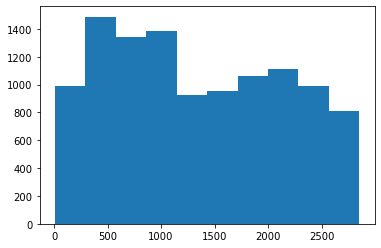

In [15]:
plt.hist(data['FL_NUM'])

In [16]:
columns=list(data.columns)

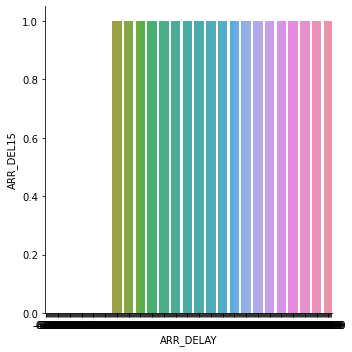

In [17]:
sns.catplot(x='ARR_DELAY',y='ARR_DEL15',data=data,kind='bar')

In [18]:
data['ARR_DEL15'].nunique()

2

In [19]:
for i in columns:
    try:
      skew1=data[i].skew()
      print("The skew of {} is {}".format(i,str(skew1)))
      if skew1 > 3:
        median = float(data[i].median())
        data[i] = np.where(data[i] > 0.45, median, data[i])
    except:
      print()

The skew of YEAR is 0
The skew of QUARTER is -0.07076578197761728
The skew of MONTH is -0.06478404626399789
The skew of DAY_OF_MONTH is -0.0039212208433480715
The skew of DAY_OF_WEEK is 0.02611051500245296


The skew of FL_NUM is 0.17421702805934322
The skew of ORIGIN_AIRPORT_ID is 0.1781563550685908

The skew of DEST_AIRPORT_ID is 0.20849436349039438

The skew of CRS_DEP_TIME is 0.06149721892776374
The skew of DEP_TIME is 0.03000709701894307
The skew of DEP_DELAY is 7.1602009024202795
The skew of DEP_DEL15 is 2.0463588064693035
The skew of CRS_ARR_TIME is -0.40688020169034556
The skew of ARR_TIME is -0.4130536257588298
The skew of ARR_DELAY is 5.898519655640514
The skew of ARR_DEL15 is 2.274840717112184
The skew of CANCELLED is 0
The skew of DIVERTED is 0
The skew of CRS_ELAPSED_TIME is 0.9028927753685997
The skew of ACTUAL_ELAPSED_TIME is 0.8903973027244532
The skew of DISTANCE is 0.7844649071893438


In [20]:
data.describe()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_TIME,...,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE
count,11043.0,11043.000000,11043.000000,11043.000000,11043.000000,11043.000000,11043.000000,11043.000000,11043.000000,11043.000000,...,11043.000000,11043.000000,11043.000000,11043.000000,11043.000000,11043.0,11043.0,11043.000000,11043.000000,11043.000000
mean,2016.0,2.548402,6.643847,15.813185,3.964774,1337.185276,12332.628271,12302.496785,1321.007154,1327.140723,...,0.142443,1537.425428,1524.224758,-14.226569,0.124513,0.0,0.0,190.595581,179.661233,1160.944490
std,0.0,1.091655,3.353072,8.789698,1.990953,810.832998,1596.321443,1602.485742,490.705288,500.631611,...,0.349520,502.495992,510.861392,8.687823,0.330181,0.0,0.0,78.425024,77.940399,643.830437
min,2016.0,1.000000,1.000000,1.000000,1.000000,7.000000,10397.000000,10397.000000,10.000000,1.000000,...,0.000000,2.000000,1.000000,-67.000000,0.000000,0.0,0.0,93.000000,75.000000,509.000000
25%,2016.0,2.000000,4.000000,8.000000,2.000000,629.000000,10397.000000,10397.000000,905.000000,905.000000,...,0.000000,1130.000000,1135.000000,-19.000000,0.000000,0.0,0.0,126.000000,117.000000,594.000000
50%,2016.0,3.000000,7.000000,16.000000,4.000000,1287.000000,12478.000000,12478.000000,1320.000000,1324.000000,...,0.000000,1559.000000,1546.000000,-10.000000,0.000000,0.0,0.0,159.000000,149.000000,907.000000
75%,2016.0,3.000000,9.000000,23.000000,6.000000,2032.000000,13487.000000,13487.000000,1735.000000,1739.000000,...,0.000000,1952.000000,1944.000000,-10.000000,0.000000,0.0,0.0,255.000000,236.000000,1927.000000
max,2016.0,4.000000,12.000000,31.000000,7.000000,2853.000000,14747.000000,14747.000000,2359.000000,2400.000000,...,1.000000,2359.000000,2400.000000,0.000000,1.000000,0.0,0.0,397.000000,428.000000,2422.000000


**Dropping off unnecessary columns**

In [21]:
data.corr()['ARR_DEL15']

YEAR                        NaN
QUARTER                0.023102
MONTH                  0.030161
DAY_OF_MONTH          -0.000597
DAY_OF_WEEK           -0.012063
FL_NUM                -0.002378
ORIGIN_AIRPORT_ID     -0.006250
DEST_AIRPORT_ID        0.029525
CRS_DEP_TIME           0.086057
DEP_TIME               0.127593
DEP_DELAY              0.200721
DEP_DEL15              0.658511
CRS_ARR_TIME           0.078282
ARR_TIME               0.042298
ARR_DELAY              0.183476
ARR_DEL15              1.000000
CANCELLED                   NaN
DIVERTED                    NaN
CRS_ELAPSED_TIME       0.015676
ACTUAL_ELAPSED_TIME    0.077741
DISTANCE               0.002870
Name: ARR_DEL15, dtype: float64

<AxesSubplot:>

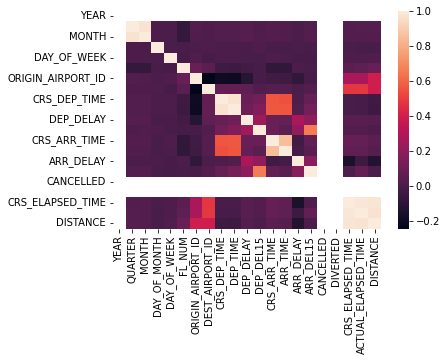

In [22]:
sns.heatmap(data.corr())

In [23]:
new_data=data.drop(['ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID','FL_NUM','YEAR','CANCELLED','DIVERTED','DISTANCE','DAY_OF_MONTH','QUARTER','MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','TAIL_NUM'],axis=1)

In [24]:
new_data.head()

,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME
0,ATL,SEA,1905,1907.0,-1.0,0.0,2143,2102.0,-41.0,0.0,338.0,295.0
1,DTW,MSP,1345,1344.0,-1.0,0.0,1435,1439.0,-10.0,0.0,110.0,115.0
2,ATL,SEA,940,942.0,-1.0,0.0,1215,1142.0,-33.0,0.0,335.0,300.0
3,SEA,MSP,819,820.0,-1.0,0.0,1335,1345.0,-10.0,0.0,196.0,205.0
4,SEA,DTW,2300,2256.0,-4.0,0.0,607,615.0,-10.0,0.0,247.0,259.0


**Label Encoding**

In [25]:
cities=new_data['ORIGIN'].unique()

In [26]:
cities

array(['ATL', 'DTW', 'SEA', 'MSP', 'JFK'], dtype=object)

In [27]:
new_data['DEST'].unique()

array(['SEA', 'MSP', 'DTW', 'ATL', 'JFK'], dtype=object)

In [28]:
city_map={cities[i]:i for i in range(0,len(cities))}

In [29]:
city_map

{'ATL': 0, 'DTW': 1, 'SEA': 2, 'MSP': 3, 'JFK': 4}

In [30]:
def encode(c):
  return city_map[c]

In [31]:
new_data['ORIGIN']=new_data['ORIGIN'].apply(encode)

In [32]:
new_data['DEST']=new_data['DEST'].apply(encode)

In [33]:
new_data.head()

,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME
0,0,2,1905,1907.0,-1.0,0.0,2143,2102.0,-41.0,0.0,338.0,295.0
1,1,3,1345,1344.0,-1.0,0.0,1435,1439.0,-10.0,0.0,110.0,115.0
2,0,2,940,942.0,-1.0,0.0,1215,1142.0,-33.0,0.0,335.0,300.0
3,2,3,819,820.0,-1.0,0.0,1335,1345.0,-10.0,0.0,196.0,205.0
4,2,1,2300,2256.0,-4.0,0.0,607,615.0,-10.0,0.0,247.0,259.0


In [34]:
new_data.corr()['ARR_DEL15']

ORIGIN                 0.034813
DEST                   0.039938
CRS_DEP_TIME           0.086057
DEP_TIME               0.127593
DEP_DELAY              0.200721
DEP_DEL15              0.658511
CRS_ARR_TIME           0.078282
ARR_TIME               0.042298
ARR_DELAY              0.183476
ARR_DEL15              1.000000
CRS_ELAPSED_TIME       0.015676
ACTUAL_ELAPSED_TIME    0.077741
Name: ARR_DEL15, dtype: float64

In [35]:

data.isnull().sum()

YEAR                   0
QUARTER                0
MONTH                  0
DAY_OF_MONTH           0
DAY_OF_WEEK            0
UNIQUE_CARRIER         0
TAIL_NUM               0
FL_NUM                 0
ORIGIN_AIRPORT_ID      0
ORIGIN                 0
DEST_AIRPORT_ID        0
DEST                   0
CRS_DEP_TIME           0
DEP_TIME               0
DEP_DELAY              0
DEP_DEL15              0
CRS_ARR_TIME           0
ARR_TIME               0
ARR_DELAY              0
ARR_DEL15              0
CANCELLED              0
DIVERTED               0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
DISTANCE               0
dtype: int64

In [36]:
data=data[["FL_NUM","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","ORIGIN","DEST","CRS_ARR_TIME","DEP_DEL15","ARR_DEL15"]]
data.isnull().sum()

FL_NUM          0
MONTH           0
DAY_OF_MONTH    0
DAY_OF_WEEK     0
ORIGIN          0
DEST            0
CRS_ARR_TIME    0
DEP_DEL15       0
ARR_DEL15       0
dtype: int64

In [37]:
data=data.fillna({'ARR_DEL15': 1})
data=data.fillna({'DEP_DEL15': 0})
data.iloc[177:185]

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
178,2839,1,9,6,DTW,JFK,1724,0.0,0.0
180,87,1,10,7,DTW,MSP,1649,1.0,0.0
181,423,1,10,7,JFK,ATL,1600,0.0,0.0
182,440,1,10,7,JFK,ATL,849,0.0,0.0
183,485,1,10,7,JFK,SEA,1945,1.0,0.0
185,589,1,10,7,MSP,SEA,1100,0.0,0.0
186,744,1,10,7,MSP,ATL,1334,0.0,0.0
187,789,1,10,7,SEA,MSP,1837,0.0,0.0


In [38]:
import math

for index, row in data.iterrows():
  data.loc[index,'CRS_ARR_TIME'] = math.floor(row['CRS_ARR_TIME'] / 100)
data.head()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
0,1399,1,1,5,ATL,SEA,21,0.0,0.0
1,1476,1,1,5,DTW,MSP,14,0.0,0.0
2,1597,1,1,5,ATL,SEA,12,0.0,0.0
3,1768,1,1,5,SEA,MSP,13,0.0,0.0
4,1823,1,1,5,SEA,DTW,6,0.0,0.0


In [39]:
from sklearn.preprocessing import  LabelEncoder
le = LabelEncoder()
data['DEST'] = le.fit_transform(data['DEST'])
data['ORIGIN'] = le.fit_transform(data['ORIGIN'])

In [40]:
data.head()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
0,1399,1,1,5,0,4,21,0.0,0.0
1,1476,1,1,5,1,3,14,0.0,0.0
2,1597,1,1,5,0,4,12,0.0,0.0
3,1768,1,1,5,4,3,13,0.0,0.0
4,1823,1,1,5,4,1,6,0.0,0.0


In [41]:
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()
z=oh.fit_transform(data['ORIGIN'].values.reshape(-1,1)).toarray()
t=oh.fit_transform(data['DEST'].values.reshape(-1,1)).toarray()

In [42]:
data=pd.get_dummies(data,columns=['ORIGIN','DEST'])

In [43]:
data['ARR_DEL15'].value_counts()

0.0    9668
1.0    1375
Name: ARR_DEL15, dtype: int64

In [44]:
data.tail()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15,ORIGIN_0,ORIGIN_1,ORIGIN_2,ORIGIN_3,ORIGIN_4,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4
11226,1715,12,30,5,12,0.0,0.0,0,1,0,0,0,1,0,0,0,0
11227,1770,12,30,5,20,1.0,0.0,0,0,0,0,1,0,0,0,1,0
11228,1823,12,30,5,22,0.0,0.0,0,1,0,0,0,0,0,0,0,1
11229,1901,12,30,5,18,0.0,0.0,1,0,0,0,0,0,0,0,0,1
11230,2005,12,30,5,9,0.0,0.0,1,0,0,0,0,0,1,0,0,0


**Split the data into dependent and independent variables**


In [45]:
x=data[[i for i in data.columns if i!='ARR_DEL15']].values
y=data[[i for i in data.columns if i=='ARR_DEL15']].values

In [46]:
x.shape

(11043, 16)

In [47]:
y.shape

(11043, 1)

# SPRINT-2

**TRAIN-TEST-SPLIT**

In [48]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [49]:
x_test.shape

(2209, 16)

In [50]:
x_train.shape

(8834, 16)

In [51]:
y_test.shape

(2209, 1)

In [52]:
y_train.shape

(8834, 1)

**STANDARDIZING INPUT VALUES**

In [53]:
sc = StandardScaler()

In [54]:
x_train=sc.fit_transform(x_train)

In [55]:
x_test=sc.fit_transform(x_test)

**MODEL BUILDING**

In [56]:
classifier = DecisionTreeClassifier(random_state=0)

In [57]:
classifier.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

In [58]:
predicted = classifier.predict(x_test)

**MODEL EVALUATION**

In [59]:
acc=accuracy_score(predicted,y_test)

In [60]:
acc

0.8791308284291535

In [61]:
data[data['ARR_DEL15']>0].iloc[33].values

array([1.187e+03, 1.000e+00, 1.500e+01, 5.000e+00, 1.900e+01, 1.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00])

In [62]:
sample=[[1.187e+03, 1.000e+00, 1.500e+01, 5.000e+00, 1.900e+01, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]]

In [63]:
classifier.predict(sample)

array([0.])

In [64]:
!pip install -U ibm-watson-machine-learning

In [74]:
from ibm_watson_machine_learning import APIClient
import json

In [75]:
wml_credentials = {
    "apikey":"zCU3gbntxqL8kInfTM2Q95jPfkfkVI9Mt8sLNC8NRipq",
    "url":"https://eu-de.ml.cloud.ibm.com"
}

In [76]:
wml_client = APIClient(wml_credentials)


In [77]:
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  -----------  ------------------------
ID                                    NAME         CREATED
d0a11148-f6ea-4361-aec2-6f11167aec40  flightdelay  2022-11-18T02:34:41.070Z
------------------------------------  -----------  ------------------------


In [78]:
SPACE_ID= "d0a11148-f6ea-4361-aec2-6f11167aec40"

In [79]:
wml_client.set.default_space(SPACE_ID)

'SUCCESS'

In [80]:
wml_client.software_specifications.list(500)

-------------------------------  ------------------------------------  ----
NAME                             ASSET_ID                              TYPE
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12       09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9        0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6            0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                       0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod     1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6                10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl        111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt

In [81]:
import sklearn 
sklearn.__version__

'1.0.2'

In [86]:
MODEL_NAME = 'flightdelay'
DEPLOYMENT_NAME = "flightdelay"
DEMO_MODEL = classifier

In [83]:
# Set Python Version
software_spec_uid = wml_client.software_specifications.get_id_by_name('runtime-22.1-py3.9')

In [84]:
# Setup model meta
model_props = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME, 
    wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0', 
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid 
}

In [87]:
#Save model
model_details = wml_client.repository.store_model(
    model=DEMO_MODEL, 
    meta_props=model_props, 
    training_data=x_train, 
    training_target=y_train
)

In [88]:
model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'label_column': 'l0',
  'schemas': {'input': [{'fields': [{'name': 'f0', 'type': 'float'},
      {'name': 'f1', 'type': 'float'},
      {'name': 'f2', 'type': 'float'},
      {'name': 'f3', 'type': 'float'},
      {'name': 'f4', 'type': 'float'},
      {'name': 'f5', 'type': 'float'},
      {'name': 'f6', 'type': 'float'},
      {'name': 'f7', 'type': 'float'},
      {'name': 'f8', 'type': 'float'},
      {'name': 'f9', 'type': 'float'},
      {'name': 'f10', 'type': 'float'},
      {'name': 'f11', 'type': 'float'},
      {'name': 'f12', 'type': 'float'},
      {'name': 'f13', 'type': 'float'},
      {'name': 'f14', 'type': 'float'},
      {'name': 'f15', 'type': 'float'}],
     'id': '1',
     'type': 'struct'}],
   'output': []},
  'software_spec': {'id': '12b83a17-24d8-5082-900f-0ab31fbfd3cb',
   'name': 'runtime-22.1-py3.9'},
  'type': 'scikit-learn_1.0'},
 'metadata': {'created_at': '2022-11-18T02:48:27.322Z',
  'id': '1dfde4a2-7

In [89]:
model_id = wml_client.repository.get_model_id(model_details)
model_id

'1dfde4a2-7300-4e47-89a1-977b7135d2ed'

In [90]:
# Set meta
deployment_props = {
    wml_client.deployments.ConfigurationMetaNames.NAME:DEPLOYMENT_NAME, 
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

In [91]:
# Deploy
deployment = wml_client.deployments.create(
    artifact_uid=model_id, 
    meta_props=deployment_props 
)



#######################################################################################

Synchronous deployment creation for uid: '1dfde4a2-7300-4e47-89a1-977b7135d2ed' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='abf3959e-b7bd-4fde-9f34-1295348fea93'
------------------------------------------------------------------------------------------------


